# PSD Estimation for ORChiD

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from math import pi

from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import os
import csv
import h5py
import requests
import numpy as np
import ligo.segments

from pycbc import DYN_RANGE_FAC
import scipy.signal as ss

In [3]:
from scipy.stats import beta
from scipy.stats import loguniform

## Getting LIGO data

Let's get 4s of data around GW150914 to use in an inference analysis. (We will need to download more data to estimate the PSD, if one isn't already available.)

In [2]:
# first, fetch a 4s segment centered on GW150914
gps = event_gps("GW150914")
start = int(gps) - 15
end = int(gps) + 15

ifos = ['H1', 'L1']

data_td_dict = {ifo: TimeSeries.fetch_open_data(ifo, start, end) for ifo in ifos}

Let's look at the time-domain data for fun (since we are using GWpy, that package will format the plot nicely for us):

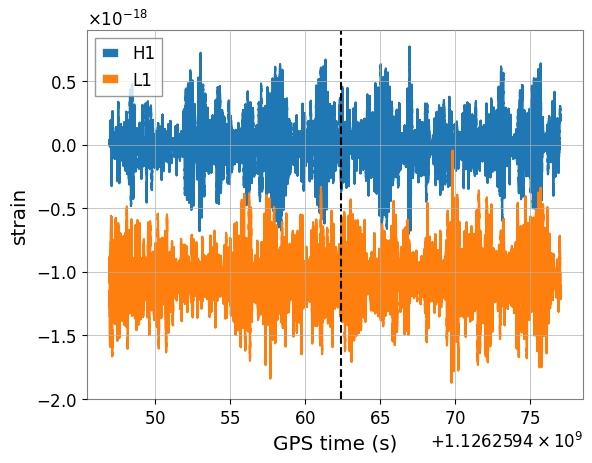

In [3]:
for ifo, data in data_td_dict.items():
    plt.plot(data, label=ifo)
plt.gca().axvline(gps, ls='--', c='k')
plt.xlabel('GPS time (s)')
plt.ylabel('strain')
plt.legend();

Let's Fourier transform the data, remembering first to window. We can do this using GWpy helper functions, or directly with numpy.

In [4]:
# GWpy normalizes the FFT like an instrumentalist would, which is not what we 
# want for the likelihoood, so fix this manually
n = len(data_td_dict[ifos[0]])
delta_t = data_td_dict[ifos[0]].dt.value

data_fd_dict = {i: (d*tukey(n, 0.2)).fft()*n*delta_t/2 
                for i,d in data_td_dict.items()}

d1 = data_fd_dict[ifos[0]].frequencies.value
d2 = np.linspace(0.0, 2048.0, int(2048./0.25)+1)

# do the same but with numpy to illustrate what's going on, with the 
# normalization we want for the likelihood
data_fd_np_dict = {i: np.fft.rfft(d*tukey(n, 0.2))*delta_t 
                   for i,d in data_td_dict.items()}
freq = np.fft.rfftfreq(n, delta_t)

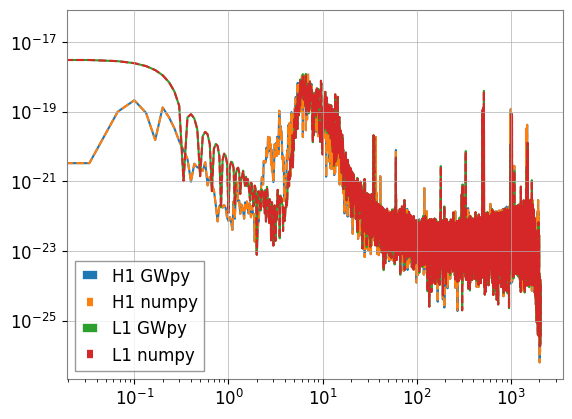

In [5]:
for ifo in ifos:
    # plot GWpy result
    plt.loglog(np.abs(data_fd_dict[ifo]), label=f"{ifo} GWpy")
    # plot numpy result
    plt.loglog(freq, np.abs(data_fd_np_dict[ifo]), label=f"{ifo} numpy", ls='--')
plt.legend();

If confused about FFT normalizations, see, e.g., the way Bilby does it [here](https://github.com/lscsoft/bilby/blob/b1e02f1dfae03d4939cae9c95eff300c22919689/bilby/core/utils/series.py#L198) vs how GWPy does it [here](https://github.com/gwpy/gwpy/blob/v2.1.4/gwpy/timeseries/timeseries.py#L130-L169); also check out a classic reference for these operations [Allen et al (2012)](https://arxiv.org/abs/gr-qc/0509116).

From the plot, notice the sharp turnover at high frequencies, which is due to the antialiasing filter that GWOSC applies; this shouldn't be a problem for us as long as we truncate the likelihood integration well before that.

### Power spectrum

Let's get some more data to estimate the PSD (or we could download a pre-made PSD from somewhere).

In [6]:
start = int(gps) - 16
end = int(gps) + 16

psd_data_td_dict = {ifo: TimeSeries.fetch_open_data(ifo, start, end) for ifo in ifos}

Compute PSD with GWpy utilities first.

In [7]:
psd_dict = {i: d.psd(fftlength=4) for i,d in psd_data_td_dict.items()}

For the first IFO, check that GWpy gave the same thing we get by calling Welch directly.

40960 8193 8193.0 24577


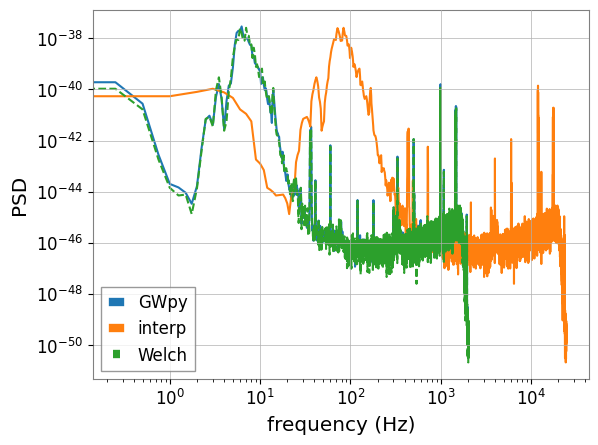

In [28]:
import scipy.signal as ss
from pycbc.psd import interpolate
from pycbc.types import FrequencySeries
ifo = 'H1'

d = psd_data_td_dict[ifo]
fs = d.sample_rate.value
nfs = 4
freq_psd, p_welch = ss.welch(d[:40960], fs=fs, nperseg=nfs*fs, average='median')
p_welch_pycbc = FrequencySeries(p_welch, delta_f=freq_psd[1]-freq_psd[0])
interp = interpolate(p_welch_pycbc, 1./12.)
print(len(d[:40960]), len(p_welch), (nfs*fs/2.)+1, len(interp))

plt.loglog(psd_dict[ifo], label='GWpy')
plt.loglog(interp, label='interp')
plt.loglog(freq_psd, p_welch, ls='--', label='Welch')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()

With the PSDs, we may whiten the data.

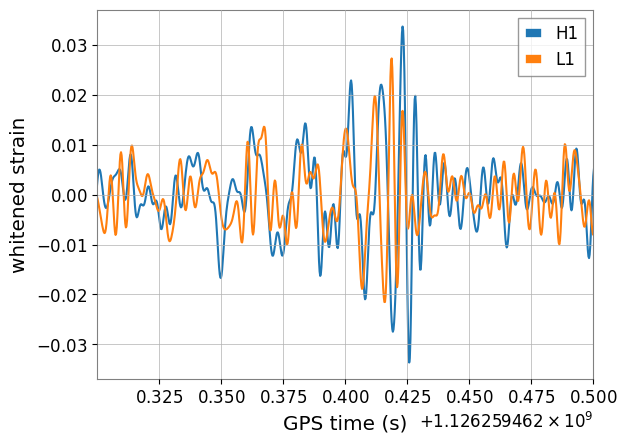

In [12]:
for i, d_fd in data_fd_dict.items():
    # whiten (missing prop constants)
    wd_fd = d_fd / np.sqrt(psd_dict[i])
    # do some brute-force bandpassing
    wd_fd[np.array(wd_fd.frequencies.data) < 30.] = 0
    wd_fd[np.array(wd_fd.frequencies.data) > 300.] = 0
    # go back to time domain and plot
    wd_td = np.fft.irfft(wd_fd.data)
    plt.plot(data_td_dict[i].times, wd_td, label=i)
plt.xlim(gps-0.1, gps+0.1)
plt.xlabel('GPS time (s)')
plt.ylabel('whitened strain')
plt.legend();

## Check the PSDs between different segments of the O3a real noise data

In [4]:
class NoiseSlice():
    """ Used to augment the start time of noise samples from continuous noise .hdf file """
    # This will become the primary noise reading function
    def __init__(self, real_noise_path="", sample_length=20.0):
        self.sample_length = sample_length
        self.min_segment_duration = self.sample_length
        self.real_noise_path = real_noise_path
        self.segment_ends_buffer = 0.0 # seconds
        self.slide_buffer = 240.0
        self.dt = 1./2048.

        save = []

        # Keep all required noise files open
        self.O3a_real_noise = h5py.File(self.real_noise_path, 'r')
        # Get detectors used
        self.detectors = ['H1', 'L1']
        # Get ligo segments and load_times from noise file
        ligo_segments, load_times = self._get_ligo_segments()
        # Get segment info and set probability of obtaining sample from segment
        self.psegment = {}
        segdurs = np.empty(len(ligo_segments), dtype=np.float64)
        for n, seg in enumerate(ligo_segments):
            key_time = str(load_times[seg][0])
            _key = f'{self.detectors[0]}/{key_time}'
            # Sanity check if _key is present in noise file
            try:
                _ = self.O3a_real_noise[_key]
            except:
                # An impossible segment duration and cond rand < segprob is never satisfied
                segdurs[n] = 0
                self.psegment[n] = [-1, -1, -1]
                continue
            
            # Set valid start and end times of given segment (not actual start time)
            # load_times[seg][0] is the same as seg[0]
            segment_length = len(np.array(self.O3a_real_noise[_key][:]))
            seg_start_idx = 0 + self.segment_ends_buffer
            seg_end_idx = segment_length - (self.sample_length + self.segment_ends_buffer)*(1./self.dt)
            # Get segment duration for calculating sampling ratio wrt all segments
            segdurs[n] = segment_length
            save.append([float(key_time), float(segment_length)])
            # Add the epoch parameter to store
            self.psegment[n] = [key_time, seg_start_idx, seg_end_idx]

        # Save segment lengths
        np.save("./segdurs_testing.npy", save)

        # Get probabilties of using segment using segment durations
        self.seg_idx = np.arange(len(segdurs))
        # segprob = list(segdurs/np.sum(segdurs))
        segprob = [1./len(segdurs)]*len(segdurs)
        # Get one choice from seg_idx based on probalities obtained from seg durations
        self.segment_choice = lambda _: np.random.choice(self.seg_idx, 1, p=segprob)[0]

    def _load_segments(self):
        tmp_dir = "./tmp"
        path = os.path.join(tmp_dir, 'segments.csv')
        # Download data if it does not exist
        if not os.path.isfile(path):
            url = 'https://www.atlas.aei.uni-hannover.de/work/marlin.schaefer/MDC/segments.csv'
            response = requests.get(url)
            with open(path, 'wb') as fp:
                fp.write(response.content)

        # Load data from CSV file
        segs = ligo.segments.segmentlist([])
        with open(path, 'r') as fp:
            reader = csv.reader(fp)
            for i, row in enumerate(reader):
                if i == 0:
                    continue
                idx, start, end = row
                segs.append(ligo.segments.segment([int(start), int(end)]))

        return segs
    
    def _get_ligo_segments(self):
        # https://lscsoft.docs.ligo.org/ligo-segments/
        segments = self._load_segments()
        
        # Restrict segments
        ligo_segments = ligo.segments.segmentlist([])
        for seg in segments:
            start, end = seg
            segduration = end - start
            # Check if segment fulfills minimum duration requirements
            if self.min_segment_duration is not None and segduration - self.slide_buffer < self.min_segment_duration:
                continue
            ligo_segments.append(ligo.segments.segment([start, end]))
        
        # Refer link provided above to ligo-segments
        # Sort the elements of the list into ascending order, and merge continuous 
        # segments into single segments. Segmentlist is modified in place. 
        # This operation is O(n log n).
        ligo_segments.coalesce()

        # Get times from each valid segment
        load_times = {}
        for seg in ligo_segments:
            for rawseg in segments:
                if seg in rawseg:
                    load_times[seg] = rawseg
                    break;
            if seg not in load_times:
                raise RuntimeError
            
        return ligo_segments, load_times
    
    def _make_sample_start_time(self, seg_start_idx, seg_end_idx):
        # Make a sample start time that is uniformly distributed within segdur
        return int(np.random.uniform(low=seg_start_idx, high=seg_end_idx))

    def get_noise_segment(self, segdeets):
        ## Get noise sample from given O3a real noise segment
        noise = []
        for det, segdeet in zip(self.detectors, segdeets):
            key_time, seg_start_idx, seg_end_idx = segdeet
            # Get sample_start_time using segment times
            # This start time will lie within a valid segment time interval
            sample_start_idx = self._make_sample_start_time(seg_start_idx, seg_end_idx)
            # Get the required portion of given segment
            sidx = sample_start_idx
            eidx = sample_start_idx + int(self.sample_length / self.dt)
            # Which key does the current segment belong to in real noise file
            # key_time provided is the start time of required segment
            key = f'{det}/{key_time}'
            # Get time series from segment and apply the dynamic range factor
            ts = np.array(self.O3a_real_noise[key][sidx:eidx]).astype(np.float64)
            if "O3a_real_noise.hdf" in self.real_noise_path:
                ts /= DYN_RANGE_FAC
            noise.append(ts)
        
        # Convert noise into np.ndarray, suitable for other transformations
        noise = np.stack(noise, axis=0)
        return noise
    
    def pick_segment(self):
        # Pick a random segment to use based on probablities set using their duration
        # Picking two different segments and start times provides an extra layer of augmentation
        # idx1 = self.segment_choice(0)
        # idx2 = self.segment_choice(0)
        idx1 = self.seg_idx[0]
        idx2 = self.seg_idx[-1]
        # Return the segment details of selected segment
        return (self.psegment[idx1], self.psegment[idx2])

    def apply(self):
        ## Get noise sample with random start time from O3a real noise
        # Toss a biased die and retrieve the segment to use
        segdeets = self.pick_segment()
        # Get noise sample with random start time (uniform within segment)
        noise = self.get_noise_segment(segdeets)
        # Return noise data
        return noise


In [ ]:
# Get the segment params from O3a real noise file
noi = NoiseSlice(real_noise_path="/local/scratch/igr/nnarenraju/O3a_real_noise/testing_real_noise.hdf")
# Data has been read and stored in .npy file. This takes 10-20 min to run.

In [11]:
data = np.load('./segdurs_testing.npy')
key_times = data[:,0]
segdurs = data[:,1]
print(data)

[[1.23820508e+09 2.01134080e+07]
 [1.23840037e+09 2.22187520e+07]
 [1.23854655e+09 1.77561600e+07]
 ...
 [1.24452290e+09 2.47029760e+07]
 [1.24454382e+09 2.66731520e+07]
 [1.24459395e+09 1.33713920e+07]]


In [6]:
O3a_real_noise = h5py.File("/local/scratch/igr/nnarenraju/O3a_real_noise/O3a_real_noise_alt.hdf", 'r')

(20480,)
(4706, 20480)


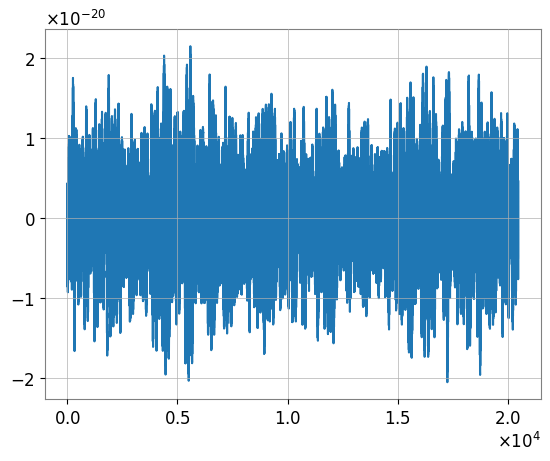

In [7]:
tss = []
times = []
for key_num in range(len(key_times)):
    det = 'H1'
    key = f'{det}/{int(key_times[key_num])}'
    sidx = 0
    eidx = int(sidx + (10. * 2048.))
    for i in range(13):
        times.append(int(key_times[key_num]))
        offset = int(2**(9+i)) if i > 0 else 0
        d = np.array(O3a_real_noise[key][sidx+offset:eidx+offset]).astype(np.float64) / DYN_RANGE_FAC
        tss.append(d)

print(tss[0].shape)
plt.plot(tss[0])
tss = np.array(tss)
print(tss.shape)

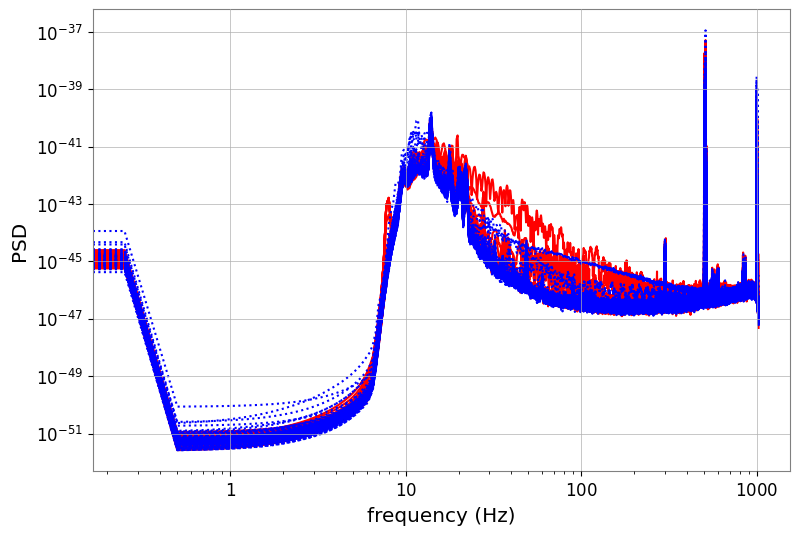

In [8]:
check = int((3./8.) * len(key_times))
fs = 2048.
plt.figure(figsize=(9.0, 6.0))

dff = 0.005
meds = {i:[] for i in range(int(1./dff))}
med_times = {i:[] for i in range(int(1./dff))}
all_psds = []
for n, (ts, time) in enumerate(zip(tss, times)):
    freq_psd, p_welch = ss.welch(ts, fs=fs, nperseg=4*fs, average='median')
    all_psds.append(p_welch)
    for i in range(int(1./dff)):
        if n < tss.shape[0] * dff*(i+1) and n >= tss.shape[0] * dff*i:
            meds[i].append(p_welch)
            med_times[i].append(time)

for n, med in meds.items():
    med = np.mean(med, axis=0)
    med_time = np.min(med_times[n])
    if med_time < key_times[check]:
        plt.loglog(freq_psd, med, ls='solid', label='Section {}'.format(n), color='red')
    else:
        plt.loglog(freq_psd, med, ls='dotted', label='Section {}'.format(n), color='blue')

plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [9]:
all_psds = np.array(all_psds)

In [ ]:
# Save all psds for L1/H1 in HDF5 file
print(all_psds.shape)
# Write PSD in HDF5 format
with h5py.File("./tmp/psds_l1_81days.hdf", 'a') as fp:
    data = all_psds
    key = 'data'
    fp.create_dataset(key, data=data, compression='gzip',
                        compression_opts=9, shuffle=True)
    fp.attrs['shape'] = all_psds.shape

(4706, 4097)


## Experimenting with manually augmenting the PSD

#### Using the beta function to augment small bins of the PSD

In [ ]:
a, b = 3.0, 5.0
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

100


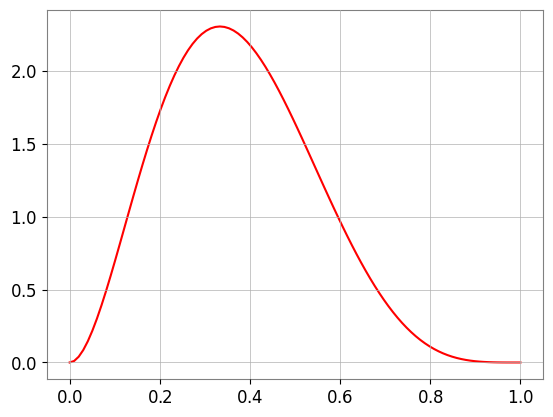

In [ ]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.0, a, b), beta.ppf(1.0, a, b), 100)
func = beta.pdf(x, a, b)
print(len(func))
ax.plot(x, func, 'r-', label='beta pdf')

#### Pick a random PSD from H1/L1 to augment (from the latter half)

In [ ]:
for n, med in meds.items():
    med = np.mean(med, axis=0)
    med_time = np.min(med_times[n])
    if med_time > key_times[check]:
        f_select, mean_psd_select = freq_psd, med

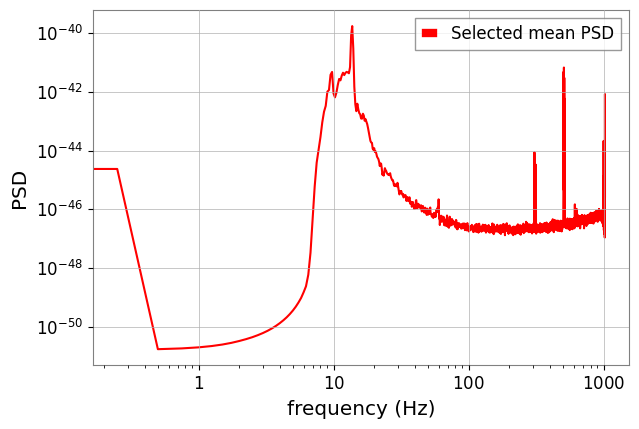

In [ ]:
plt.figure(figsize=(9.0/1.3, 6.0/1.3))
plt.loglog(f_select, mean_psd_select, ls='solid', label='Selected mean PSD'.format(n), color='red')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.show()

#### Choose the frequency range over which we augment

In [ ]:
augmentation_f_lower = 15.0 #Hz (low frequency bound of noise)
augmentation_f_upper = 1024.0 #Hz (high frequency bound based on Nyquist limit)

#### Choose the number of augmenting features that we will be adding

In [ ]:
ad_hoc_num_components = np.random.randint(1, 8)

#### Choose the upper and lower frequency bounds of all components

In [ ]:
# Define augmentation components
aug_bins = {d:[] for d in range(ad_hoc_num_components)}

In [ ]:
# Length of PSD in the required frequency range
f_start_idx = len(f_select) - len(f_select[f_select >= 10.0])
f_end_idx = len(f_select) - len(f_select[f_select >= 250.0])
length_of_req_frange = f_end_idx - f_start_idx
print(length_of_req_frange)
print(f_start_idx, f_end_idx)

960
40 1000


In [ ]:
# Upper and lower bound for the size of the frequency bin
# Each PSD from 15 Hz to 1024 Hz should contain 
aug_comp_binlength_lbound = length_of_req_frange//5
aug_comp_binlength_ubound = length_of_req_frange
print(aug_comp_binlength_lbound, aug_comp_binlength_ubound)

192 960


In [ ]:
for aug_key in aug_bins.keys():
    start_idx = loguniform.rvs(f_start_idx, f_end_idx-aug_comp_binlength_lbound)
    length = np.random.uniform(aug_comp_binlength_lbound, aug_comp_binlength_ubound - start_idx)
    end_idx = start_idx + length
    # start_idx, end_idx
    aug_bins[aug_key] = [int(start_idx), int(end_idx)]

In [ ]:
for key, val in aug_bins.items():
    print(key, val, val[1]-val[0])

0 [323, 593] 270
1 [448, 716] 268


#### Choose the scale of each component depending on the associated frequency bounds

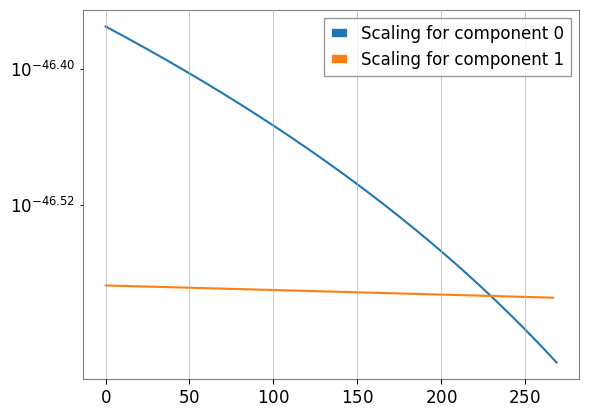

In [ ]:
# Multiplying the augmentation component with the segment below should give us the right scale
scaling = {d:[] for d in range(ad_hoc_num_components)}
for aug_key in aug_bins.keys():
    idx1, idx2 = aug_bins[aug_key][0], aug_bins[aug_key][1]
    linear_segment = np.linspace(mean_psd_select[idx1], mean_psd_select[idx2], idx2-idx1)
    scaling[aug_key] = linear_segment
    plt.plot(linear_segment, label='Scaling for component {}'.format(aug_key))
    plt.yscale('log')
    plt.legend()

#### Choose the shape of the component using a Beta distribution (not used as PDF, used for shape)

In [ ]:
aug_components = {d:[] for d in range(ad_hoc_num_components)}

In [ ]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

In [ ]:
lb, ub = [0.1, 5.0]
for aug_key in aug_bins.keys():
    if np.random.rand() < 0.9:
        a, b = [np.random.uniform(lb, ub), np.random.uniform(lb, ub)]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), aug_bins[aug_key][1]-aug_bins[aug_key][0])
        func = beta.pdf(x, a, b)
    else:
        mu, sig = [0.5, np.random.uniform(0, 5)]
        x = np.linspace(0, 1, aug_bins[aug_key][1]-aug_bins[aug_key][0])
        func = gaussian(x, mu, sig)
    
    # Add some G noise as well, why the heck not
    mu, sigma = [1e-48, np.random.uniform(0, 1)]
    noise = np.random.normal(mu, sigma, aug_bins[aug_key][1]-aug_bins[aug_key][0])
    aug_components[aug_key] = (func * scaling[aug_key]) + (noise * scaling[aug_key])
    aug_components[aug_key][aug_components[aug_key] < 1e-47] = 1e-47
    print(len(aug_components[aug_key]))

270
268


#### Add each of these components to the PSD

In [ ]:
augmented_psd = mean_psd_select.copy()

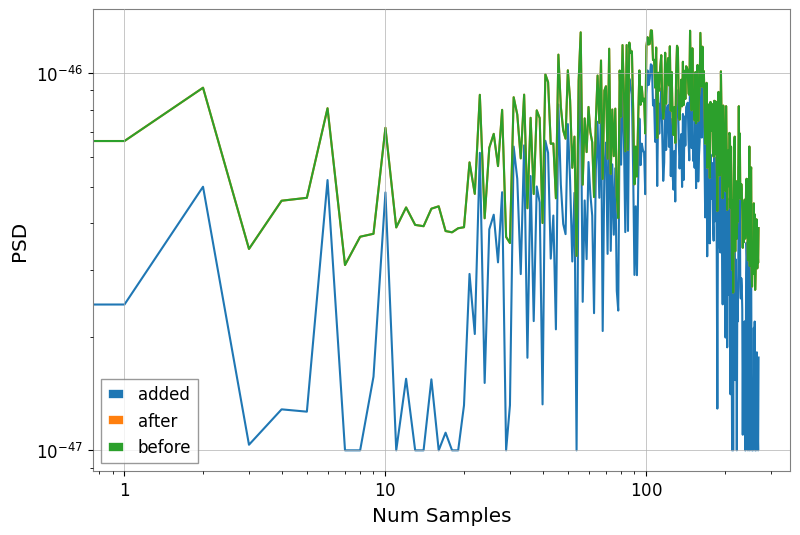

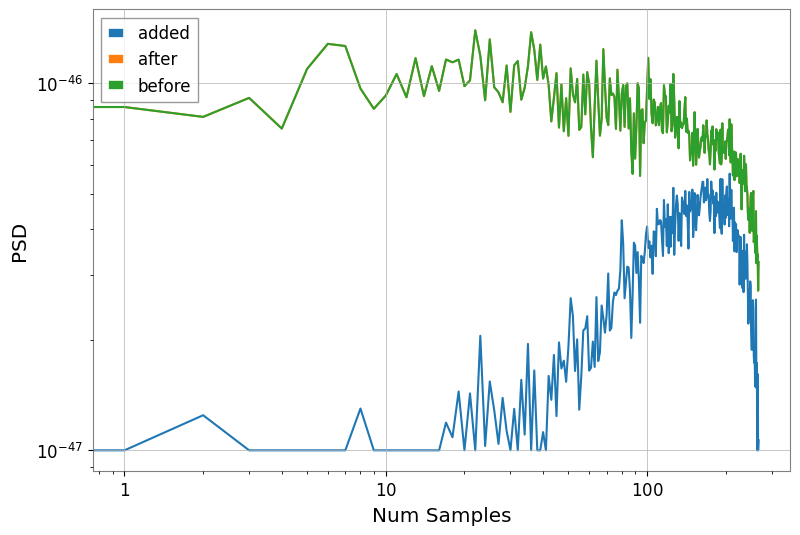

In [ ]:
for aug_key in aug_bins.keys():
    plt.figure(figsize=(9.0, 6.0))
    order_of_mag = np.random.randint(low=1, high=2)
    order_of_mag = 1
    # Components
    psd_before = augmented_psd[aug_bins[aug_key][0]: aug_bins[aug_key][1]]
    added_bit = aug_components[aug_key] * order_of_mag
    # Augment
    augmented_psd[aug_bins[aug_key][0]: aug_bins[aug_key][1]] += (aug_components[aug_key] * order_of_mag)
    # Plotting
    psd_after = augmented_psd[aug_bins[aug_key][0]: aug_bins[aug_key][1]]
    plt.loglog(added_bit, label='added')
    plt.loglog(psd_after, label='after')
    plt.loglog(psd_before, label='before')
    plt.xlabel('Num Samples')
    plt.ylabel('PSD')
    plt.legend()
    plt.show()

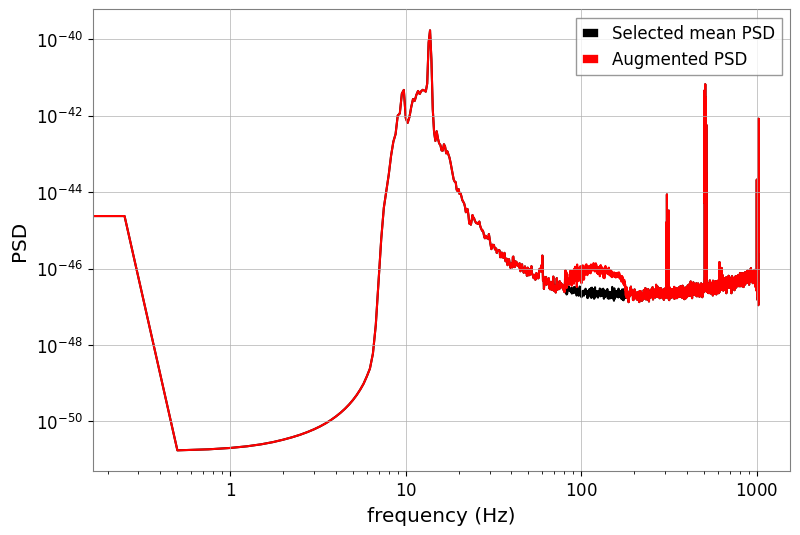

In [ ]:
plt.figure(figsize=(9.0, 6.0))
plt.plot(f_select, mean_psd_select, ls='solid', label='Selected mean PSD'.format(n), color='black')
plt.plot(f_select, augmented_psd, ls='solid', label='Augmented PSD'.format(n), color='red')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

## Get PSDs from testing data

In [5]:
class NoiseSlice():
    """ Used to augment the start time of noise samples from continuous noise .hdf file """
    # This will become the primary noise reading function
    def __init__(self, real_noise_path="", sample_length=20.0,
                 segment_llimit=None, segment_ulimit=None):
        self.sample_length = sample_length
        self.min_segment_duration = self.sample_length
        self.real_noise_path = real_noise_path
        self.slide_buffer = 240.0
        self.dt = 1./2048.

        # Keep all required noise files open
        self.O3a_real_noise = h5py.File(self.real_noise_path, 'r')
        # Get detectors used
        self.detectors = ['H1', 'L1']
        # Get ligo segments and load_times from noise file
        ligo_segments, load_times = self._get_ligo_segments()
        # Get segment info and set probability of obtaining sample from segment
        # limit check
        if segment_ulimit == -1:
            segment_ulimit = len(ligo_segments)
        
        self.psegment = {}
        lookup = np.load("./tmp/segdurs_all.npy")
        for n, seg in enumerate(ligo_segments):
            key_time = str(load_times[seg][0])
            _key = f'{self.detectors[0]}/{key_time}'
            # Sanity check if _key is present in noise file
            if n >= segment_llimit and n <= segment_ulimit:
                segment_length = lookup[:,1][n]
                seg_start_idx = 0
                seg_end_idx = segment_length - (self.sample_length)*(1./self.dt)
                self.psegment[n] = [key_time, seg_start_idx, seg_end_idx]
            else:
                # An impossible segment duration and cond rand < segprob is never satisfied
                self.psegment[n] = [-1, -1, -1]

    def _load_segments(self):
        tmp_dir = "./tmp"
        path = os.path.join(tmp_dir, 'segments.csv')
        # Download data if it does not exist
        if not os.path.isfile(path):
            url = 'https://www.atlas.aei.uni-hannover.de/work/marlin.schaefer/MDC/segments.csv'
            response = requests.get(url)
            with open(path, 'wb') as fp:
                fp.write(response.content)

        # Load data from CSV file
        segs = ligo.segments.segmentlist([])
        with open(path, 'r') as fp:
            reader = csv.reader(fp)
            for i, row in enumerate(reader):
                if i == 0:
                    continue
                idx, start, end = row
                segs.append(ligo.segments.segment([int(start), int(end)]))

        return segs
    
    def _get_ligo_segments(self):
        # https://lscsoft.docs.ligo.org/ligo-segments/
        segments = self._load_segments()
        
        # Restrict segments
        ligo_segments = ligo.segments.segmentlist([])
        for seg in segments:
            start, end = seg
            segduration = end - start
            # Check if segment fulfills minimum duration requirements
            if self.min_segment_duration is not None and segduration - self.slide_buffer < self.min_segment_duration:
                continue
            ligo_segments.append(ligo.segments.segment([start, end]))
        
        # Refer link provided above to ligo-segments
        # Sort the elements of the list into ascending order, and merge continuous 
        # segments into single segments. Segmentlist is modified in place. 
        # This operation is O(n log n).
        ligo_segments.coalesce()

        # Get times from each valid segment
        load_times = {}
        for seg in ligo_segments:
            for rawseg in segments:
                if seg in rawseg:
                    load_times[seg] = rawseg
                    break;
            if seg not in load_times:
                raise RuntimeError
            
        return ligo_segments, load_times
    
    def _make_sample_start_times(self, seg_start_idx, seg_end_idx):
        # Make a sample start time that is uniformly distributed within segdur
        seg_start_idx = int(seg_start_idx)
        seg_end_idx = int(seg_end_idx)
        return [foo for foo in range(seg_start_idx, seg_end_idx, int(self.sample_length*(1./self.dt)))]

    def get_noise_segments(self, det=None):
        ## Get noise sample from given O3a real noise segment
        ## Calculate the PSDs and save them for usage
        psds = []
        with tqdm(total=len(self.psegment.keys())) as pbar:
            pbar.set_description("Segment PSD Gen")
            for n, segdeet in self.psegment.items():
                key_time, seg_start_idx, seg_end_idx = segdeet
                pbar.update()
                if key_time == -1:
                    continue
                # Get sample_start_time using segment times
                sample_start_idxs = self._make_sample_start_times(seg_start_idx, seg_end_idx)
                # Get the required portions of given segment
                for sample_start_idx in sample_start_idxs:
                    sidx = sample_start_idx
                    eidx = sample_start_idx + int(self.sample_length / self.dt)
                    key = f'{det}/{key_time}'
                    # Get time series from segment and apply the dynamic range factor
                    ts = np.array(self.O3a_real_noise[key][sidx:eidx]).astype(np.float64)
                    if "O3a_real_noise.hdf" in self.real_noise_path:
                        ts /= DYN_RANGE_FAC
                    # Calculate the PSD for each sample and store
                    fs = 2048. # Hz
                    freq_psd, p_welch = ss.welch(ts, fs=fs, nperseg=4*fs, average='median')
                    # save_psd_freqs = freq_psd.copy()
                    # np.save("./freq_psd.npy", save_psd_freqs)
                    # df should be 0.25 Hz for the above setting
                    # print('check_df = {}'.format(freq_psd[1]-freq_psd[0])) 
                    psds.append(p_welch)
        
        # Convert noise into np.ndarray
        psds = np.stack(psds, axis=0)
        # Write PSD in HDF5 format
        with h5py.File("./tmp/psds_{}_latter30days_20s_.hdf".format(det), 'a') as fp:
            data = psds
            key = 'data'
            fp.create_dataset(key, data=data, compression='gzip',
                                compression_opts=9, shuffle=True)
            fp.attrs['shape'] = psds.shape

    def apply(self, det=None):
        ## Get noise sample with random start time from O3a real noise
        self.get_noise_segments(det=det)

In [6]:
freq_psd = np.load("./tmp/freq_psd.npy")

#### Testing dataset PSDs

In [55]:
# Looking at 30 days of testing noise
ns = NoiseSlice(real_noise_path="/local/scratch/igr/nnarenraju/O3a_real_noise/O3a_real_noise.hdf",
                sample_length=20.0, segment_llimit=0, segment_ulimit=132)
# Running the noise segmentation + PSD estimation module
# Detector H1 (2592000./20. = 129_600 different PSDs)
ns.apply(det='H1')
# Running the noise segmentation + PSD estimation module
# Detector L1 (2592000./20. = 129_600 different PSDs)
ns.apply(det='L1')

In [66]:
# Testing dataset PSDs
h1_psds_testing = h5py.File("./tmp/psds_H1_30days.hdf", 'r')['data'][:]
l1_psds_testing = h5py.File("./tmp/psds_L1_30days.hdf", 'r')['data'][:]
# Calculate median PSDs of the full 30 days
median_psd_h1_testing = np.median(h1_psds_testing, axis=0)
median_psd_l1_testing = np.median(l1_psds_testing, axis=0)

In [70]:
# Split all estimated psds and get the mean 
# The median hides the outliers
print('Mean of {} PSDs estimated every 20 seconds from O3a'.format(129_600 / 20_000))
h1_psds_split_testing = np.array_split(h1_psds_testing, 20_000)[:]
l1_psds_split_testing = np.array_split(l1_psds_testing, 20_000)[:]
h1_mean_psds_testing = [np.mean(h1_psds_split_i, axis=0) for h1_psds_split_i in h1_psds_split_testing[:-1]]
l1_mean_psds_testing = [np.mean(l1_psds_split_i, axis=0) for l1_psds_split_i in l1_psds_split_testing[:-1]]

Mean of 6.48 PSDs estimated every 20 seconds from O3a


#### Training dataset PSDs

In [54]:
# Looking at 30 days of testing noise
ns = NoiseSlice(real_noise_path="/local/scratch/igr/nnarenraju/O3a_real_noise/O3a_real_noise.hdf",
                sample_length=20.0, segment_llimit=133, segment_ulimit=-1)
# Running the noise segmentation + PSD estimation module
# Detector H1 (2592000./20. = 129_600 different PSDs)
ns.apply(det='H1')
# Running the noise segmentation + PSD estimation module
# Detector L1 (2592000./20. = 129_600 different PSDs)
ns.apply(det='L1')

Segment PSD Gen: 100%|██████████| 362/362 [11:35<00:00,  1.92s/it]


In [71]:
# Training dataset PSDs
h1_psds_training = h5py.File("./tmp/psds_H1_latter51days_20s.hdf", 'r')['data'][:]
l1_psds_training = h5py.File("./tmp/psds_L1_latter51days_20s.hdf", 'r')['data'][:]
# Calculate median PSDs of the full 30 days
median_psd_h1_training = np.median(h1_psds_training, axis=0)
median_psd_l1_training = np.median(l1_psds_training, axis=0)

In [72]:
# Training duration
tdur = 51. * 24. * 3600. # seconds
num_psds_training = tdur / 20.0
print('num psds = {}'.format(num_psds_training))
print('num_splits = {}'.format(num_psds_training/6.5))

num psds = 220320.0
num_splits = 33895.38461538462


In [73]:
### TRAINING DATASET
# Split all estimated psds and get the mean 
# The median hides the outliers
print('Mean of {} PSDs estimated every 20 seconds from O3a'.format(220_320 / 33_895))
h1_psds_split_training = np.array_split(h1_psds_training, 33_895)[:]
l1_psds_split_training = np.array_split(l1_psds_training, 33_895)[:]
h1_mean_psds_training = [np.mean(h1_psds_split_i, axis=0) for h1_psds_split_i in h1_psds_split_training[:-1]]
l1_mean_psds_training = [np.mean(l1_psds_split_i, axis=0) for l1_psds_split_i in l1_psds_split_training[:-1]]

Mean of 6.500073757191326 PSDs estimated every 20 seconds from O3a


#### Looking at worst PSDs

In [22]:
# Find the area under PSD (this is not a good idea)
idxs_1 = np.argwhere((freq_psd > 15.) & (freq_psd < 50.)).flatten()
idxs_2 = np.argwhere((freq_psd > 50.) & (freq_psd < 100.)).flatten()
idxs_3 = np.argwhere((freq_psd > 100.) & (freq_psd < 320.)).flatten()
idxs_4 = np.argwhere((freq_psd > 320.) & (freq_psd < 500.)).flatten()

idxs_unique = list(set(np.concatenate((idxs_1, idxs_2, idxs_3, idxs_4))))

h1_scores = {n: np.array([np.trapz(psd[idxs]) for psd in h1_psds_testing]) for n, idxs in enumerate([idxs_1, idxs_2, idxs_3, idxs_4, idxs_unique])}
l1_scores = {n: np.array([np.trapz(psd[idxs]) for psd in l1_psds_testing]) for n, idxs in enumerate([idxs_1, idxs_2, idxs_3, idxs_4, idxs_unique])}

In [34]:
# Get the n-most deviant PSDs
n = 1936
h1_worst_idxs = {num: np.argpartition(h1_scores[num], -n)[-n:] for num in range(5)}
l1_worst_idxs = {num: np.argpartition(l1_scores[num], -n)[-n:] for num in range(5)}

h1_worst_idxs_all = np.array(list(h1_worst_idxs.values())).flatten()
l1_worst_idxs_all = np.array(list(l1_worst_idxs.values())).flatten()

#### Overplot of PSDs for training and testing

H1 PSDS - testing dataset


0it [00:00, ?it/s]

19998it [00:17, 1154.17it/s]


L1 PSDS - testing dataset


19998it [00:16, 1216.38it/s]


H1 PSDS - training dataset


33893it [00:29, 1134.13it/s]


L1 PSDS - training dataset


33893it [00:36, 918.85it/s] 


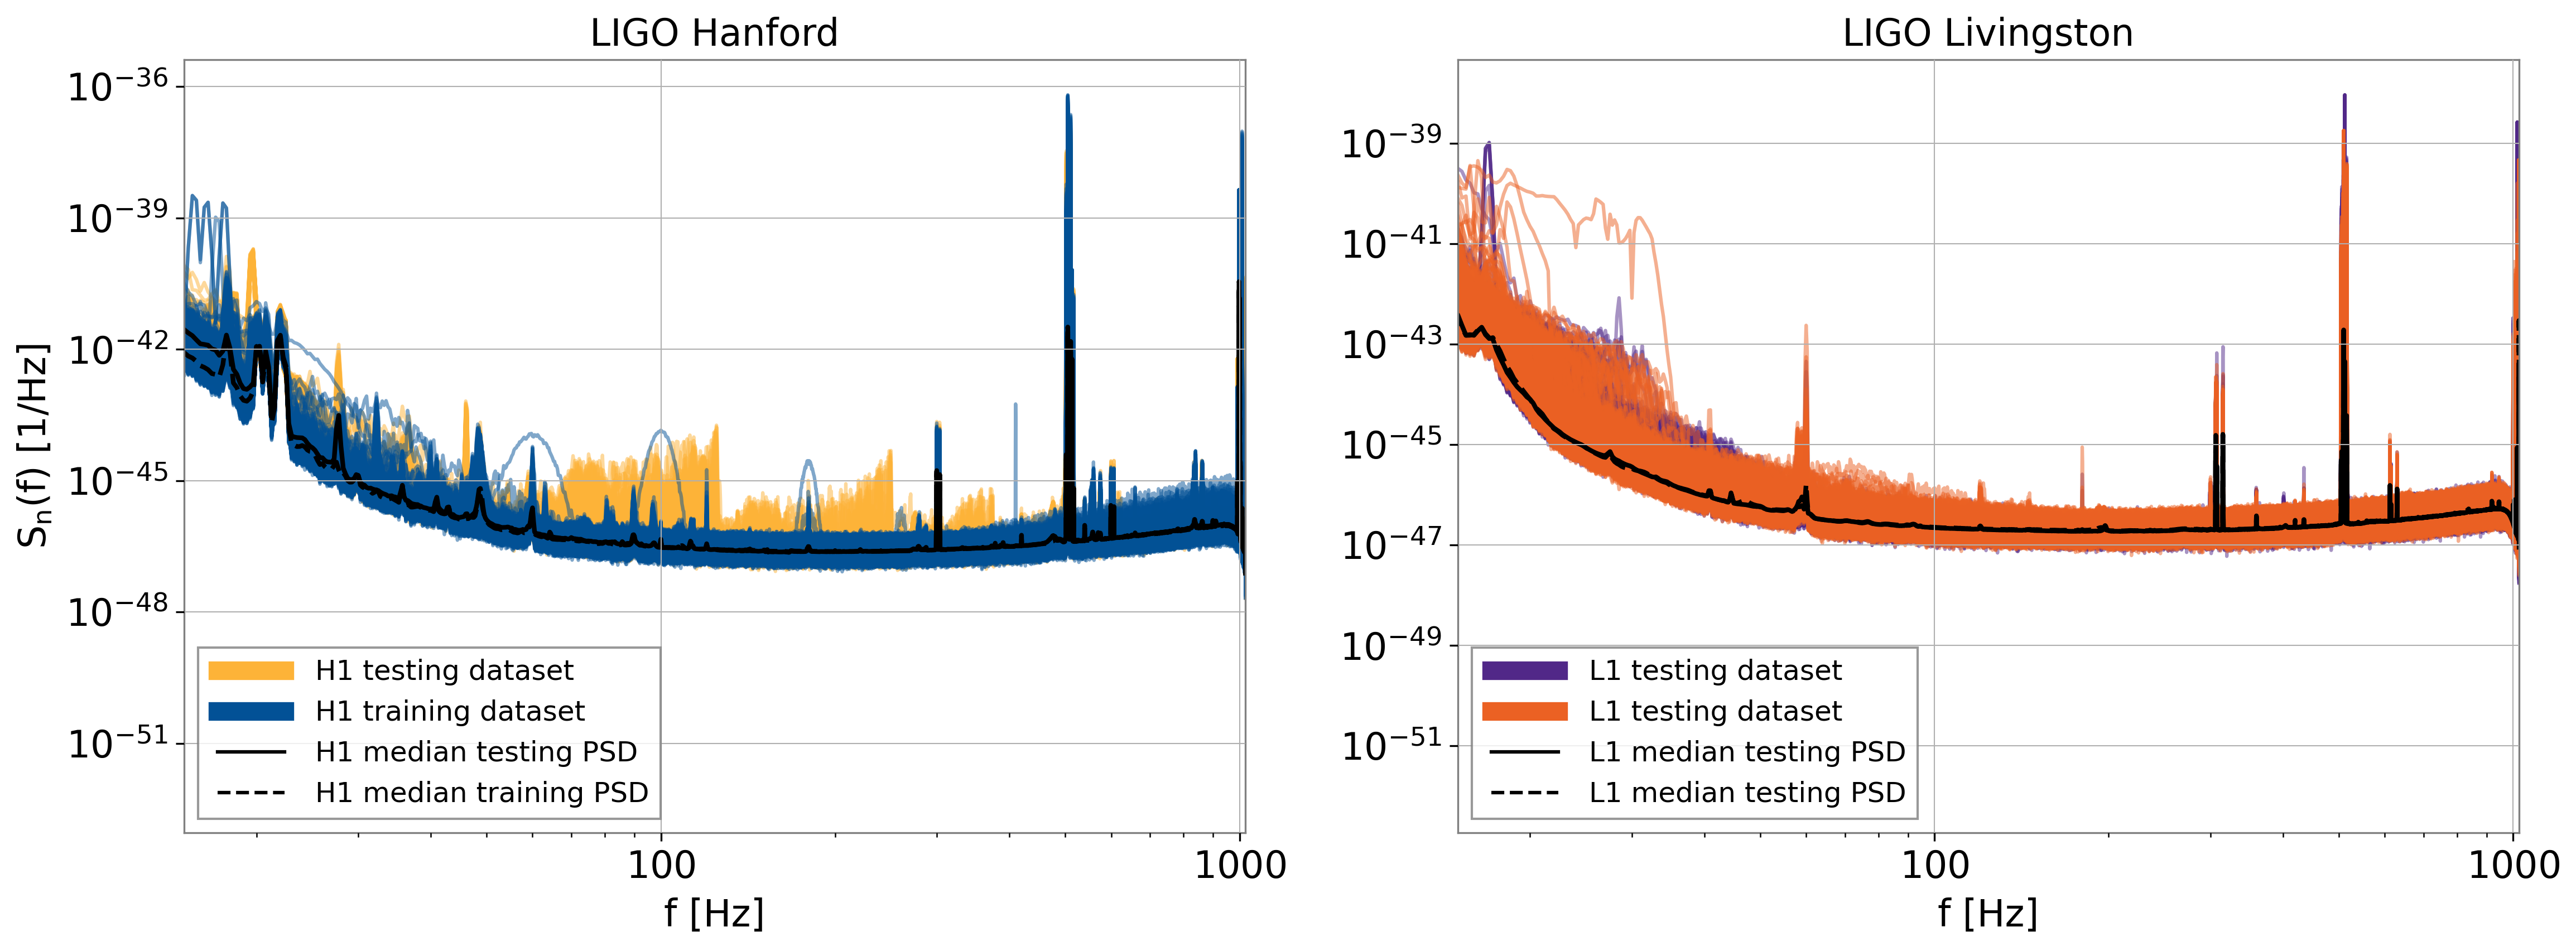

In [114]:
# Making pretty plots for the paper
fig, ax = plt.subplots(1, 2, figsize=(18.0, 6.0), dpi=300)

ncurves = -1

"""
np.array([235, 97, 35])/255. # Orange
np.array([81, 40, 136])/255. # Purple
np.array([194, 106, 119])/255. # Dark Pink
np.array([81, 40, 136])/255. # Purple
# Pair yellow-pink
np.array([219, 16, 72])/255. # Pink
np.array([244, 179, 1])/255. # Yellow
"""

### TESTING
print('H1 PSDS - testing dataset')
alpha = 0.5
for n, h1_psd in tqdm(enumerate(h1_mean_psds_testing[:ncurves])):
    c = np.array([253, 179, 56])/255. # Yellow
    if n == 0:
        ax[0].loglog(freq_psd, h1_psd, c=c, linewidth=1.5, alpha=alpha, label='H1 testing dataset')
    else:
        ax[0].loglog(freq_psd, h1_psd, c=c, linewidth=1.5, alpha=alpha)

print('L1 PSDS - testing dataset')
for n, l1_psd in tqdm(enumerate(l1_mean_psds_testing[:ncurves])):
    c = np.array([81, 40, 136])/255. # Purple
    if n == 0:
        ax[1].loglog(freq_psd, l1_psd, c=c, linewidth=1.5, alpha=alpha, label='L1 testing dataset')
    else:
        ax[1].loglog(freq_psd, l1_psd, c=c, linewidth=1.5, alpha=alpha)

### TRAINING
print('H1 PSDS - training dataset')
alpha = 0.5
for n, h1_psd in tqdm(enumerate(h1_mean_psds_training[:ncurves])):
    c = np.array([2, 81, 150])/255. # Blue
    if n == 0:
        ax[0].loglog(freq_psd, h1_psd, c=c, linewidth=1.5, alpha=alpha, label='H1 training dataset')
    else:
        ax[0].loglog(freq_psd, h1_psd, c=c, linewidth=1.5, alpha=alpha)

print('L1 PSDS - training dataset')
for n, l1_psd in tqdm(enumerate(l1_mean_psds_training[:ncurves])):
    c = np.array([235, 97, 35])/255. # Orange
    if n == 0:
        ax[1].loglog(freq_psd, l1_psd, c=c, linewidth=1.5, alpha=alpha, label='L1 testing dataset')
    else:
        ax[1].loglog(freq_psd, l1_psd, c=c, linewidth=1.5, alpha=alpha)


# Plot the median PSD alongside all segment PSDs for each detector
ax[0].plot(freq_psd, median_psd_h1_testing, c='k', linewidth=2, label='H1 median testing PSD')
ax[1].plot(freq_psd, median_psd_l1_testing, c='k', linewidth=2, label='L1 median testing PSD')

ax[0].plot(freq_psd, median_psd_h1_training, c='k', linewidth=2, linestyle='dashed', label='H1 median training PSD')
ax[1].plot(freq_psd, median_psd_l1_training, c='k', linewidth=2, linestyle='dashed', label='L1 median testing PSD')

# We change the fontsize of minor ticks label 
fontsize = 16
ax[0].set_title('LIGO Hanford', fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[0].set_xlim(15., 1024.)
ax[0].set_ylabel(r'$\mathregular{S_n}$(f) [1/Hz]', fontsize=fontsize)
ax[0].set_xlabel(r'f [Hz]', fontsize=fontsize)

ax[1].set_title('LIGO Livingston', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].set_xlim(15., 1024.)
ax[1].set_xlabel(r'f [Hz]', fontsize=fontsize)

leg1 = ax[0].legend(loc='lower left', handlelength=3, fontsize=12)
leg2 = ax[1].legend(loc='lower left', handlelength=3, fontsize=12)
# change the line width for the legend
for n, (line1, line2) in enumerate(zip(leg1.get_lines(), leg2.get_lines())):
    line1.set_alpha(1.0)
    line2.set_alpha(1.0)
    if n in [2, 3]:
        line1.set_linewidth(1.5)
        line2.set_linewidth(1.5)
    if n in [0, 1]:
        line1.set_linewidth(8.0)
        line2.set_linewidth(8.0)

plt.savefig('./testing_dataset_psds.png')

## PSD Shifting

In [5]:
original_psds = h5py.File("./tmp/psds_H1_30days.hdf", 'r')['data'][:10]

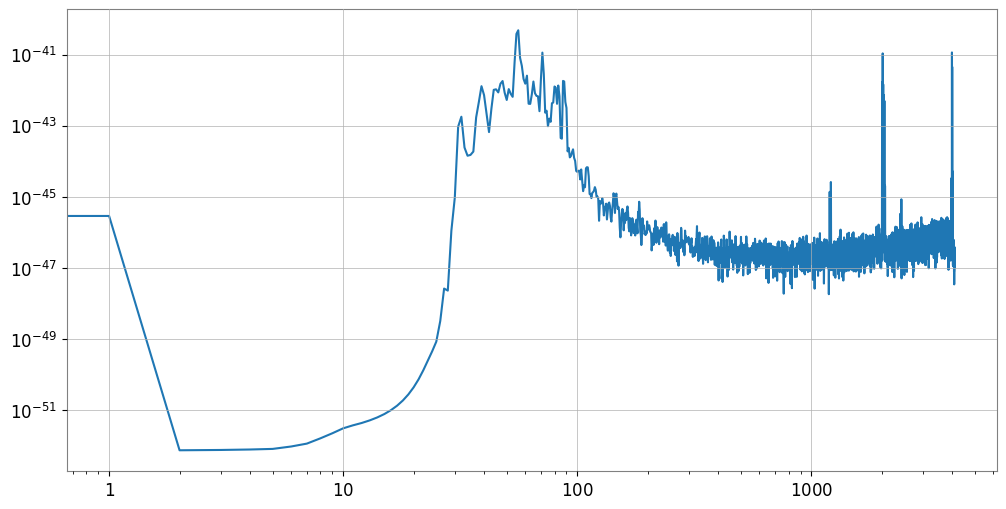

In [6]:
plt.figure(figsize=(12.0, 6.0))
plt.loglog(original_psds[0])
plt.show()

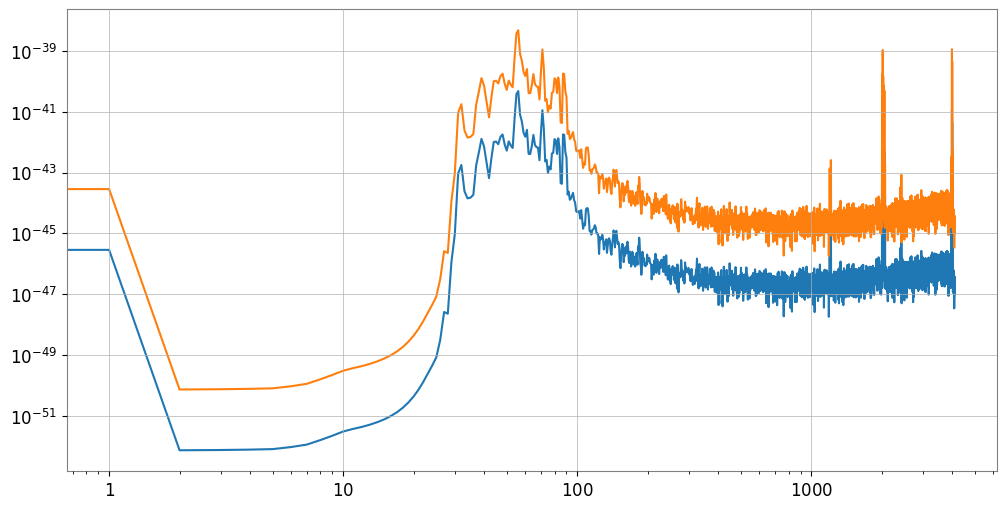

In [7]:
shifted_psd = original_psds[0] * 100.0
plt.figure(figsize=(12.0, 6.0))
plt.loglog(original_psds[0])
plt.loglog(shifted_psd)
plt.show()

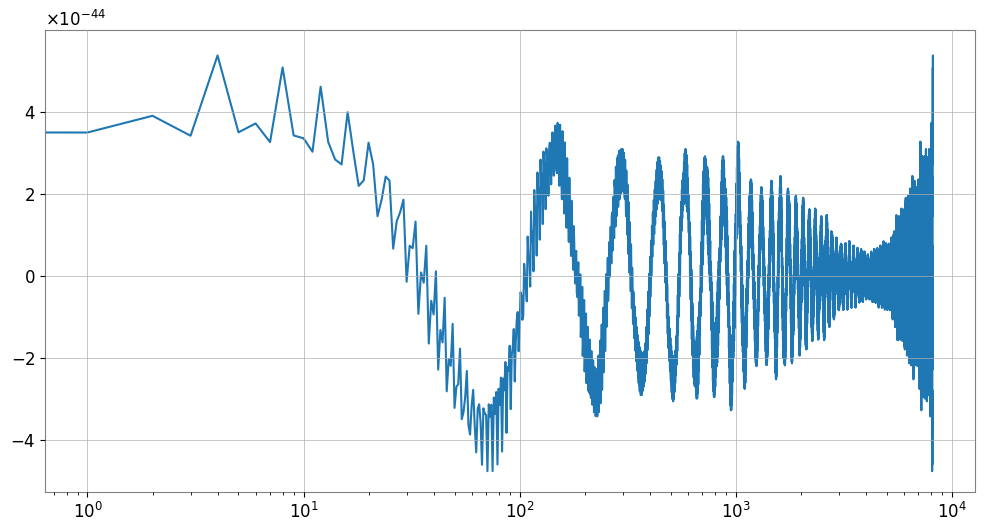

In [9]:
# How does a PSD look in the time domain?
ts_psd = np.fft.irfft(original_psds[1])
plt.figure(figsize=(12.0, 6.0))
plt.plot(ts_psd)
plt.xscale('log')
plt.show()